# Лабораторная работа №3
Система с идентификацией параметров.

### 1. Модель системы и закон управления

$\dot P = - P^3 + dm + v(t)$

$\dot dm = -dm + G \, tanh(\omega)$


Закон управления, синтезированный по методу АКАР

$w=(-3 P^5 + 2 P^3 + 3 P^2 dm + 3 P^2 v(t) + 3 P^2 v_0 - P + Pd - dm - 2 v(t) - 2 v_0)/G$

для    $P = Pd$

### 2. Вспомогательные модули для моделирования


Базовый класс для моделирования контроллера

In [1]:
import math
import numpy
import matplotlib.pyplot as plt 
import scipy.integrate as mdl 
import math

class PLC:
    def __init__(self, gain, step):
        self.last_t = 0.0
        self.last_call_t = 0.0
        self.last_u = 0
        self.step = step
        self.last_e = 0.0
        self.gain = gain
        self.u = []
        self.ulim = []
        self.t = []
        
    def getLimitedOutput(self,value):
        return math.tanh(value)
        
    def addOutputValue(self,time,value):
        self.t.append(time)
        self.u.append(value)
        self.ulim.append(self.getLimitedOutput(value))
        
    def output(self, x, t):
        self.addOutputValue(t, self.last_u)
        self.last_u = self.control(x, t)
        self.last_t = t
        self.addOutputValue(t,self.last_u)
        
        return self.gain*self.ulim[-1]

def calculate(func, x0, step, time, plc):
    result = {'t': [], 'u':[]}
    for i in range(0,len(x0)):
        result['x' + str(i + 1)] = []
    rstep = plc.step
    ode_step = step
    timev = numpy.linspace(0.0, time, int(time/rstep+1))
    for ti in timev:
        uk = plc.output(x0, ti)
        tk = numpy.linspace(ti, ti+rstep, int(rstep/ode_step+1))
        y = mdl.odeint(func(uk), x0, tk)
        x0 = y[-1]
        result['t'].extend(tk[:-1])
        for i in range(0,len(x0)):
            result['x' + str(i + 1)].extend(y[:-1,i])
        result['u'].extend([uk for i in tk[:-1]])
    return result


Правая часть дифференциального уравнения объекта со ступенчатым изменением параметра

In [2]:
def F_with_change(step_time, init_value, finish_value):
    def F_with_control(uc):
        def F_internal(x, t):
            if t > step_time:
                v = finish_value
            else:
                v = init_value
            return [ -math.pow(x[0],3) + x[1] + v, -x[1] + uc] 
    
        return F_internal
    return F_with_control

Вывод результатов моделирования

In [3]:
def plot_result(time, time_end, x1, x2, plc, goal):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(time,x1, 'r-', time, x2, 'b-') 
    plt.plot([0, time_end], [goal, goal], color='#FF0000',linestyle='--') 
    plt.subplot(1,2,2)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(plc.t, plc.u,'b-',plc.t,plc.ulim,'r-')
    plt.plot([0, tk], [1, 1], 'r--',[0, tk], [-1, -1], 'r--',[0, tk],[0, 0],'r:')  
    plt.ylim([-2.0, 2.0])
    plt.show()

####3. Моделирование САУ с адаптивным регулятором идентификационного типа

Реализация алгоритма адаптивного управления на основе идентификации неизвестных параметров модели использует следующие идеи:

- расширение размерности исходной системы с целью устранения нелинейностей модели (новые переменные это нелинейные функции показаний датчика);
- формирование линейной модели процесса в расширенном пространстве переменных;
- накопление истории измерений фиксированной длинны внутри контроллера;
- использование метода наименьших квадратов для вычисления параметров линейной модели процеса;
- подстановка полученных параметров в функцию управления, полученную по методу АКАР.

Постановка задачи идентификации на основе модели линейной регрессии


$\dot P = \theta \, P^3 + dm + v(t), \, v(t) \approx const$ ,

$y = a\,x + b, \,\, y=\dot P - dm, \,\, x = P^3, \,\, a = \theta, \,\, b=v,\,\, \dot P_k \approx \frac{P_k - P_{k-1}}{\Delta t}$ 

Реализация адаптивного регулятора (см. пакет sklearn
https://scikit-learn.org/stable/)

In [4]:
import math
import numpy as np
import sklearn.linear_model as linmod

class ADCS_ident(PLC):
    def __init__(self, goal, gain, dt):
        super(ADCS_ident,self).__init__(gain, dt)
        self.G = gain
        self.Pd = goal
        self.x_history = []
        self.x_history_len = 30
        self.dt = dt
        self.coeff = {'t':[0.0], 'a':[0.0], 'b':[0.0]}
        
    def transform(self, x, t):
        return [x[0], x[1], math.pow(x[0],3.0)]
    
    def identification(self, x, t):
        self.x_history.append(x)
        if len(self.x_history) > self.x_history_len:
            self.x_history.pop(0)
        if len(self.x_history) > 1:
            z = np.array([self.transform(zi, t) for zi in (np.array(self.x_history)[:-1])])
            y = np.diff(np.array(self.x_history),axis=0)/self.dt
            y1 = y[:,0] - z[:,1]
            model = linmod.LinearRegression(normalize=True)
            model.fit(X=z[:,2].reshape(-1,1), y=y1)
            self.coeff['t'].append(t)
            self.coeff['a'].append(model.coef_)
            self.coeff['b'].append(model.intercept_)
    
    def control(self, x, t):
        self.identification(x, t)
        v0 = self.coeff['b'][-1]
        a = self.coeff['a'][-1]
        P = x[0]
        G = self.gain
        dm = x[1]
        Pd = self.Pd
        return (-3*math.pow(P,5)*a*a - 2*math.pow(P,3)*a - 3*math.pow(P,2)*a*dm 
                - 3*math.pow(P,2)*a*v0 - P + Pd - dm - 2*v0)/G
       

Тест регулятора

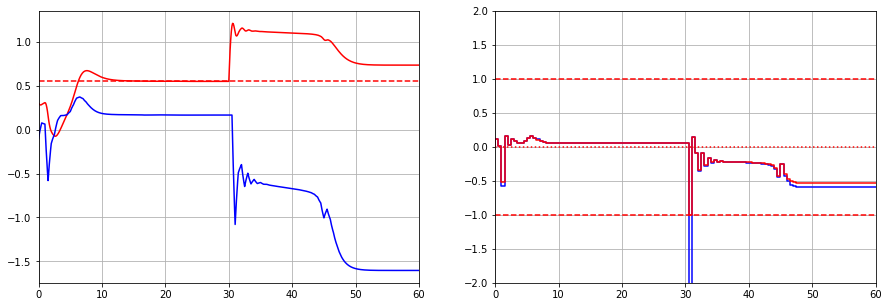

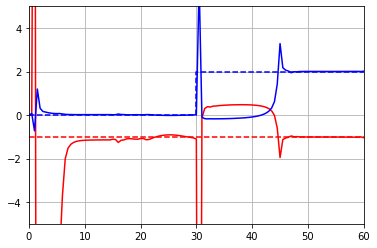

In [5]:
v0_init = 0.0
v0_finish = 2.0
change_time = 30
goal = 0.55
gain = 3
step = 0.5
mod_step = 0.1
tk = 60
x0 = [0.3, -0.1]
func_ctrl = F_with_change(change_time,v0_init,v0_finish)

reg = ADCS_ident(goal=goal, gain=gain, dt=step)
res = calculate(func_ctrl, x0, mod_step, tk, reg)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=reg, goal=goal)

tend = tk
plt.figure()
plt.plot(reg.coeff['t'], reg.coeff['a'], 'r', [0, tk], [-1, -1], 'r--',
         reg.coeff['t'], reg.coeff['b'], 'b', [0, change_time, change_time, tk], [v0_init, v0_init, v0_finish, v0_finish], 'b--')
plt.ylim([-5.0, 5.0])
plt.xlim([0, tk])
plt.grid()
plt.show()